In [1]:
import pandas
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from dataset import get_dataset

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
-------------------------
Number of images: 10015
Number of MEL images: 1113
Number of NV images: 6705
Number of BCC images: 514
Number of AKIEC images: 327
Number of BKL images: 1099
Number of DF images: 115
Number of VASC images: 142
Unique age values: [25. 30. 55. 70. 85. 50. 40. 45. 65. 75. 60. 35. nan 15. 20. 80.  5. 10.]
Unique values diagnosis_confirm_type: ['histopathology' 'single image expert consensus'
 'serial imaging showing no change'
 'confocal microscopy with consensus dermoscopy']
Unique values diagnosis: ['nevus' 'pigmented benign keratosis' 'melanoma' 'basal cell carcinoma'
 'vascular lesion' 'dermatofibroma' 'squamous cell carcinoma'
 'actinic kera

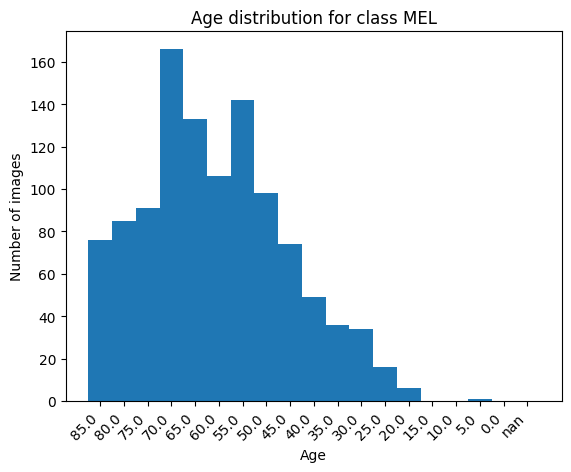

Stats for MEL:
{'male': 689, 'female': 424, 'diagnosis_confirm_type': {'histopathology': 1113, 'single image expert consensus': 0, 'serial imaging showing no change': 0, 'confocal microscopy with consensus dermoscopy': 0}}


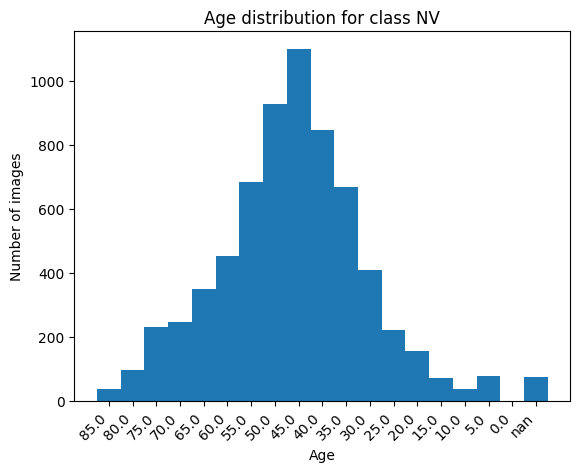

Stats for NV:
{'male': 3423, 'female': 3282, 'diagnosis_confirm_type': {'histopathology': 2498, 'single image expert consensus': 503, 'serial imaging showing no change': 3704, 'confocal microscopy with consensus dermoscopy': 0}}


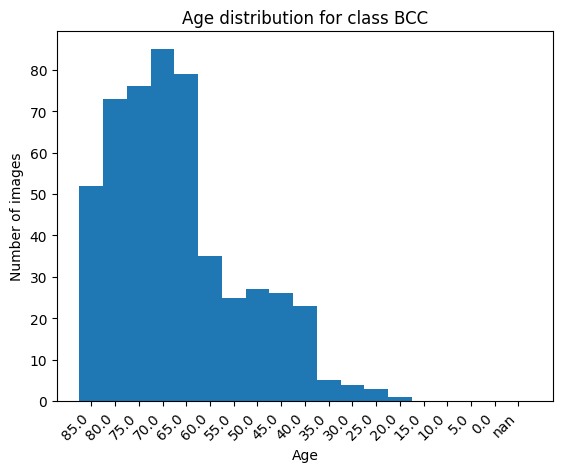

Stats for BCC:
{'male': 317, 'female': 197, 'diagnosis_confirm_type': {'histopathology': 514, 'single image expert consensus': 0, 'serial imaging showing no change': 0, 'confocal microscopy with consensus dermoscopy': 0}}


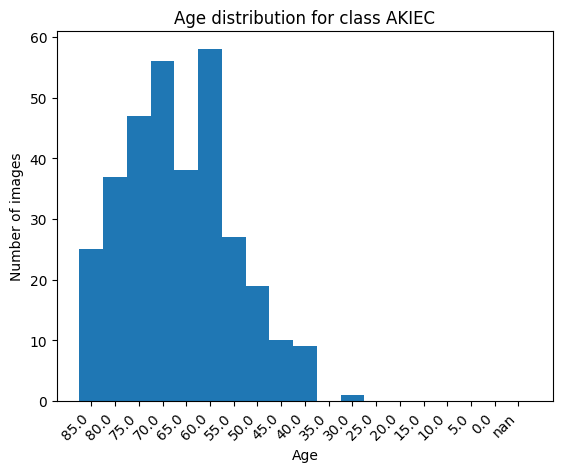

Stats for AKIEC:
{'male': 221, 'female': 106, 'diagnosis_confirm_type': {'histopathology': 327, 'single image expert consensus': 0, 'serial imaging showing no change': 0, 'confocal microscopy with consensus dermoscopy': 0}}


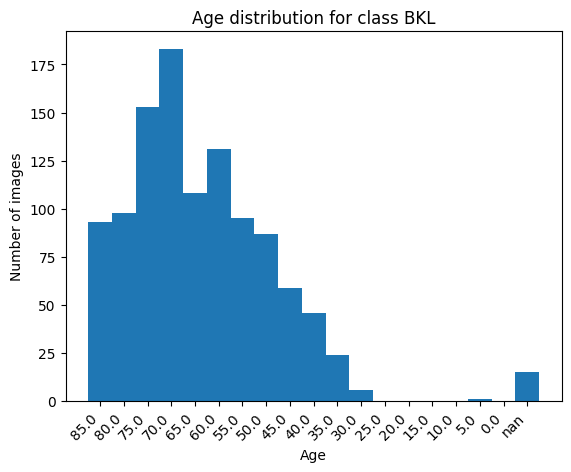

Stats for BKL:
{'male': 626, 'female': 473, 'diagnosis_confirm_type': {'histopathology': 766, 'single image expert consensus': 264, 'serial imaging showing no change': 0, 'confocal microscopy with consensus dermoscopy': 69}}


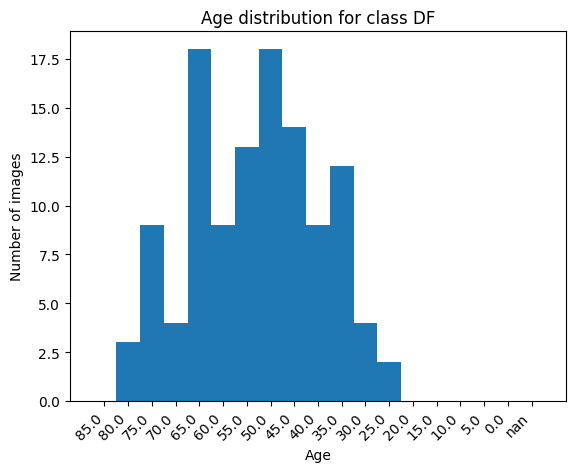

Stats for DF:
{'male': 63, 'female': 52, 'diagnosis_confirm_type': {'histopathology': 55, 'single image expert consensus': 60, 'serial imaging showing no change': 0, 'confocal microscopy with consensus dermoscopy': 0}}


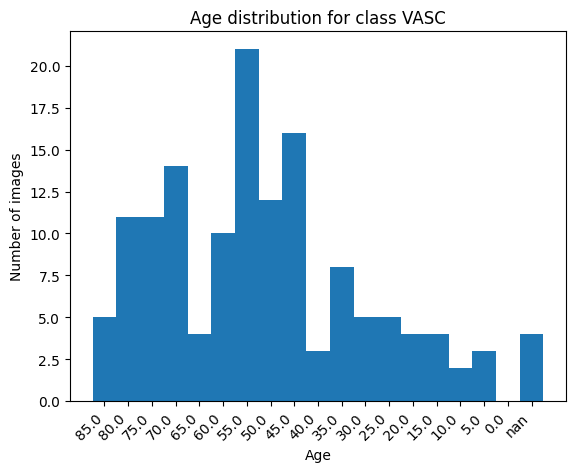

Stats for VASC:
{'male': 69, 'female': 73, 'diagnosis_confirm_type': {'histopathology': 67, 'single image expert consensus': 75, 'serial imaging showing no change': 0, 'confocal microscopy with consensus dermoscopy': 0}}


In [2]:
df_images = pandas.read_csv("data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")

print(df_images.head())
print("-------------------------")
print(f"Number of images: {len(df_images.index)}")
for column in df_images:
    if column == "image":
        continue
    print(f"Number of {column} images: {len(df_images[df_images[column] == 1].index)}")


df_metadata = pandas.read_csv("data/ISIC2018_Task3_Training_GroundTruth/metadata.csv")
print(f"Unique age values: {df_metadata['age_approx'].unique()}")
print(f"Unique values diagnosis_confirm_type: {df_metadata['diagnosis_confirm_type'].unique()}")
print(f"Unique values diagnosis: {df_metadata['diagnosis'].unique()}")

for column in df_images:
    stats = {"male": 0, "female": 0,
             "age": {"85.0": 0, "80.0": 0, "75.0": 0, "70.0": 0, "65.0": 0, "60.0": 0, "55.0": 0, "50.0": 0, "45.0": 0, "40.0": 0, "35.0": 0, "30.0": 0, "25.0": 0, "20.0": 0, "15.0": 0, "10.0": 0, "5.0": 0, "0.0": 0, "nan": 0},
             "diagnosis_confirm_type": {'histopathology': 0, 'single image expert consensus': 0, 'serial imaging showing no change': 0, 'confocal microscopy with consensus dermoscopy': 0}
             }
    if column == "image":
        continue
    for isic_id in df_images[df_images[column] == 1]["image"]:
        if len(df_metadata[df_metadata["isic_id"] == isic_id]["sex"].index) != 0 and df_metadata[df_metadata["isic_id"] == isic_id]["sex"].iloc[0] == "male":
            stats["male"] = stats["male"] + 1
        else:
            stats["female"] = stats["female"] + 1

        age = df_metadata[df_metadata["isic_id"] == isic_id]["age_approx"]
        if len(age.index) != 0:
            stats["age"][str(age.iloc[0])] = stats["age"][str(age.iloc[0])] + 1
        else:
            stats["age"]["nan"] = stats["age"]["nan"] + 1

        diagnosis_confirm_type = df_metadata[df_metadata["isic_id"] == isic_id]["diagnosis_confirm_type"].iloc[0]
        stats["diagnosis_confirm_type"][diagnosis_confirm_type] = stats["diagnosis_confirm_type"][diagnosis_confirm_type] + 1
    plt.title(f"Age distribution for class {column}")
    plt.xlabel("Age")
    plt.ylabel("Number of images")
    plt.bar(stats["age"].keys(), stats["age"].values(), width=1.0)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print(f"Stats for {column}:")
    stats.pop("age")
    print(stats)

In [3]:
# Calculate the mean and std of images
data_set = get_dataset(dataset_name="train", use_plain_transform=True, under_sampling="True")
# Adapted from: https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html
data_loader = DataLoader(data_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=False, num_workers=1)
cnt = 0
fst_moment = torch.empty(3)
snd_moment = torch.empty(3)

for images, _ in data_loader:
    b, c, h, w = images.shape
    nb_pixels = b * h * w
    sum_ = torch.sum(images, dim=[0, 2, 3])
    sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
    fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
    snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
    cnt += nb_pixels

mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

print("mean and std: \n", mean, std)

mean and std: 
 tensor([192.1314, 141.6559, 147.6526]) tensor([33.1019, 38.3609, 43.3686])
